In [1]:
# Loading in libraries necessary for CNN
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, Adagrad, RMSprop, SparseAdam, LBFGS, Adadelta
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot
import time
import torch.nn.functional as F
import nmrsim
from nmrsim import plt
from itertools import product

# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
files = glob.glob('./Spectral_Data/spectral_data/1200MHz/*.csv')
print('Total number of files: ', len(files))

Total number of files:  2000


Establishing a Dataloader for 1200MHz dataset

In [3]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading
        self.files = glob.glob(os.path.join('./Spectral_Data/spectral_data/1200MHz', 
                                                       'spectral_data_*.csv'))

        self.y_60 = []
        self.y_1200 = []

        for self.file in self.files:
            self.df = pd.read_csv(self.file)
            self.array_60 = self.df['60MHz_intensity'].to_numpy()
            self.array_1200 = self.df['1200MHz_intensity'].to_numpy()
            self.y_60.append(self.array_60)
            self.y_1200.append(self.array_1200)
            

        self.tensor_60 = torch.Tensor(self.y_60).float().to(device)        

        self.tensor_1200 = torch.Tensor(self.y_1200).float().to(device)
        
        self.num_samples = len(self.y_60)

    def __getitem__(self, index):
        return self.tensor_60[index], self.tensor_1200[index]
    
    def __len__(self):
        return self.num_samples
    
  

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(5500,2250) # input layer to hidden
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(2250,1024) # input layer to output
        self.fc3 = nn.Linear(1024,512)
        self.fc4 = nn.Linear(512, 4000)
        self.fc5 = nn.Linear(4000, 5500)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [5]:
model = NeuralNetwork().to(device)

In [6]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_1200,
                                                    test_size=0.2)

# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

/home/garrettreinhard/miniconda3/envs/isotope/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


In [7]:
criterion = nn.MSELoss()

In [8]:
#Adagrad and RMSprop seems to work ptetty well
optimizer = RMSprop(model.parameters(), lr=0.0001)

In [9]:
num_epochs = 200

In [10]:
x = time.time()

for e in range(num_epochs):
    running_loss = 0.0
    for index, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.squeeze()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    
    if(int(e) % 100) == 0:
        print(f'Epoch {e+1} loss: {epoch_loss:.4f}')

print(f'Time Elapsed: {round(time.time()-x, 5)} seconds')

Epoch 1 loss: 0.0003
Epoch 101 loss: 0.0002
Time Elapsed: 40.91132 seconds


In [11]:
# Evaluating Model Performance

model.eval() # Model to evaluation mode

test_loss = 0.0
test_correct = 0
test_total = 0

# Loop for testing
for inputs, labels in test_dataloader:
    #Forward pass
    inputs = inputs.squeeze()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item() * inputs.size(0)
    
    _, labels = torch.max(labels.squeeze(), 1)
    _, predicts = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicts == labels).sum().item()

accuracy = (test_correct / test_total)*100
test_loss /= len(test_dataloader.dataset)
print(f' Mean Loss of Function: {test_loss}, Accuracy: {accuracy}')

 Mean Loss of Function: 0.0003368433623109013, Accuracy: 1.25


In [12]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        predictions = model(inputs)

predictions_numpy = predictions.cpu().numpy()
pred = pd.DataFrame(predictions_numpy)

In [13]:
df_60 = pd.read_csv('./Spectral_Data/spectral_data/1200MHz/spectral_data_05_00064.csv')
df_x = df_60['60MHz_intensity']
df_x = df_x.to_numpy()
df_x = torch.Tensor(df_x).to(device)

In [14]:
predictions = model(df_x)
predictions_numpy = predictions.detach().cpu().numpy()
predictions_numpy

array([ 0.00398319, -0.00346352, -0.00249501, ...,  0.00679013,
        0.00092619, -0.00027115], dtype=float32)

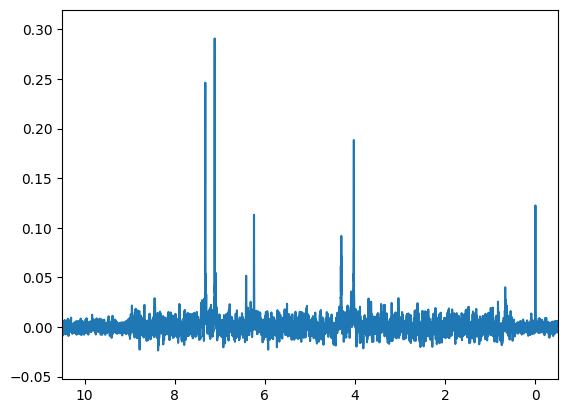

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([ 0.00398319, -0.00346352, -0.00249501, ...,  0.00679013,
         0.00092619, -0.00027115], dtype=float32))

In [15]:
x = np.linspace(-.5,10.5,5500)
y = predictions_numpy


nmrsim.plt.mplplot_lineshape(x, y, limits=(-0.5, 10.5))

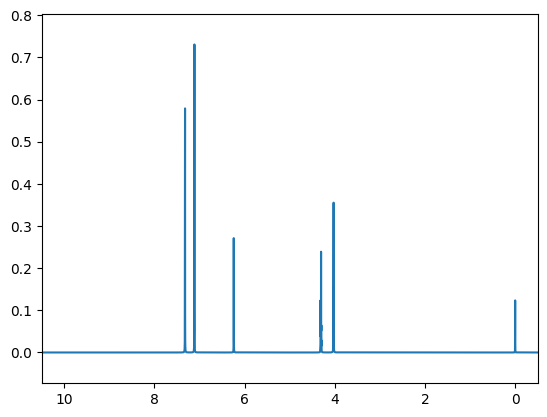

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([4.34597590e-07, 4.37457972e-07, 4.40352316e-07, ...,
        1.79809157e-07, 1.79613227e-07, 1.79417631e-07]))

In [16]:
nmrsim.plt.mplplot_lineshape(np.array(df_60['1200MHz_ppm']), np.array(df_60['1200MHz_intensity']), limits=(-0.5, 10.5))

In [ ]:
test = glob.glob(os.path.join('./Spectral_Data/spectral_data/1200MHz', 
                                                       'spectral_data_*.csv'))

y_60 = []
y_1200 = []

for file in test:
    df = pd.read_csv(file)
    array_60 = df['60MHz_intensity'].to_numpy()
    array_1200 = df['1200MHz_intensity'].to_numpy()
    y_60.append(array_60)
    y_1200.append(array_1200)

tensor = torch.Tensor(y_1200)
reshaped_tensor = tensor.unsqueeze(1)

reshaped_tensor.shape